빅데이터 기말 프로젝트 : 레시피 추천

In [3]:

import re
import io
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from wordcloud import WordCloud

from ipywidgets import interact, interactive, fixed, VBox, HBox, widgets, Output, Layout, Button
from IPython.display import display, HTML, clear_output


# 파일 경로 
file_path = "C:\\Users\\셜록\\Downloads\\TB_RECIPE_SEARCH_241226.csv"

# CSV 파일 불러오기
try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    # 'utf-8'로 실패하면 'cp949'  시도
    df = pd.read_csv(file_path, encoding='cp949')

# 필요한 열의 결측값 처리 (문자열로 대체)
df['CKG_MTRL_CN'] = df['CKG_MTRL_CN'].fillna('')
df['CKG_STA_ACTO_NM'] = df['CKG_STA_ACTO_NM'].fillna('선택 안함')
df['CKG_KND_ACTO_NM'] = df['CKG_KND_ACTO_NM'].fillna('선택 안함')

# 레시피 데이터 확인
print(f"총 레시피 수: {len(df)}")
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

총 레시피 수: 23192


In [4]:
# --- 재료 추출 함수 정의 (숫자 포함 재료 제거 로직 추가) ---
def extract_pure_ingredients_final(material_string):
    """
    숫자 포함 재료 제거, 괄호/ 문자 처리, 다중 구분자, 수량/단위 제거 등을 수행하는 최종 함수.
    """
    if pd.isna(material_string) or not isinstance(material_string, str):
        return []

    # 1.  제어 문자를 공백으로 치환하여 분리 오류 방지
    clean_string = str(material_string).replace('', ' ')

    # 2. 대괄호 안의 카테고리 정보 제거 ([재료], [소스])
    clean_string = re.sub(r'\[.*?\]', '', clean_string).strip()
    
    # 3. 괄호와 괄호 안의 내용 삭제 ((예: 채썰기))
    clean_string = re.sub(r'\s*\([^)]*\)', '', clean_string).strip() 
    
    # 4. 다중 구분자 통합 및 재료 항목 분리
    clean_string = clean_string.replace('|', ',').replace(' 또는 ', ',').replace(' 혹은 ', ',')
    items = [item.strip() for item in clean_string.split(',') if item.strip()]
    
    pure_ingredients = set()
    
    # 5. 패턴: 수량, 단위, 기호 및 모호한 단어 제거 (항목 끝에서 제거)
    unit_pattern = r'(\s*[\d\.\/()]+[\s\-\/\d]*[^\s]*|\s*(T|t|스푼|개|마리|모|줄|쪽|컵|조각|덩이|줌|장|통|술|숟가락|kg|g|ml|공기|포기|적당량|약간|조금|씩|정도|대|분량|선택|취향|간|큰|작은))+$'
    
    # 6. 최종 필터링 단어 목록 (비재료 단어 및 오류 유발 단어)
    non_ingredient_terms = {'물', '육수', '소스', '가루', '기타', '그외', '용', '재움용', '양념용', '데코용', '고명용', '레시피', '첨가', '후추', '소금'}

    for item in items:
        # 7. 재료명만 남기기 위해 패턴 제거 (단위/수량 제거)
        pure_name = re.sub(unit_pattern, '', item, flags=re.IGNORECASE).strip()
        
        # 8. 불필요한 특수 문자/숫자만 포함된 문자열 제거
        if re.fullmatch(r'[^가-힣a-zA-Z\s]+', pure_name):
            continue

        # 9. 복합 재료명 분리 및 최종 필터링
        sub_names = [n.strip() for n in re.split(r'\s{1,}', pure_name) if n.strip()]
        
        for name in sub_names:
            # 10. 숫자가 포함된 재료명 제외
            if re.search(r'\d', name):
                continue
                
            # 11. 1글자 이하, 필터링 단어 제거
            if len(name) >= 2 and name not in non_ingredient_terms:
                pure_ingredients.add(name)
            
    return sorted(list(pure_ingredients))

# --- 데이터 로딩 및 처리 ---
try:
    df = pd.read_csv(file_path, encoding='cp949')
except UnicodeDecodeError:
    try:
        df = pd.read_csv(file_path, encoding='euc-kr')
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding='utf-8')

print(f"✅ 데이터 로딩 완료. 총 {len(df)}개의 레시피.")

# 'CKG_MTRL_CN' 열에 최종 함수 적용
df['Extracted_Materials_Final'] = df['CKG_MTRL_CN'].apply(extract_pure_ingredients_final)

print("\n✅ 최종 강화 로직을 통한 재료 추출 완료 (숫자 및 모든 필터링 포함).")

# 추출 결과 테스트 
test_strings = [
    "[재료] 닭고기 1마리| 7번 소스 1T| 양파 1/2개 (채썰기)", # '7번 소스'가 제외되어야 함
    "소고기다짐육100g| 1등급 한우 300g", # '1등급 한우'가 제외되어야 함
    "양파1큰| 베이비채소| 스프링클",
    "[재료] 떡국떡400g| 다진소고기100g"
]
for ts in test_strings:
    print(f"테스트: {ts[:40]}... -> 추출: {extract_pure_ingredients_final(ts)}")

✅ 데이터 로딩 완료. 총 23192개의 레시피.

✅ 최종 강화 로직을 통한 재료 추출 완료 (숫자 및 모든 필터링 포함).
테스트: [재료] 닭고기 1마리| 7번 소스 1T| 양파 1/2개 (채썰기)... -> 추출: ['닭고기', '양파']
테스트: 소고기다짐육100g| 1등급 한우 300g... -> 추출: ['소고기다짐육', '한우']
테스트: 양파1큰| 베이비채소| 스프링클... -> 추출: ['베이비채소', '스프링클', '양파']
테스트: [재료] 떡국떡400g| 다진소고기100g... -> 추출: ['다진소고기', '떡국떡']


In [ ]:
# --- 재료 빈도 계산 ---
all_materials = [material for sublist in df['Extracted_Materials_Final'] for material in sublist]
material_counts = pd.Series(all_materials).value_counts()

top_n = 50
top_materials = material_counts.head(top_n)
tail_n = 20
tail_materials = material_counts.tail(tail_n)

print(f"\n✅ 상위 {top_n}개 최다 사용 재료 (분석):")
print(top_materials.head(10))
print(f"\n✅ 하위 {tail_n}개 최다 사용 재료 (분석):")
print(tail_materials)



✅ 상위 50개 최다 사용 재료 (분석):
설탕      6892
양파      6724
대파      6391
참기름     6164
다진마늘    5739
고춧가루    4701
통깨      4056
마늘      3913
식용유     3492
청양고추    3187
Name: count, dtype: int64

✅ 하위 20개 최다 사용 재료 (분석):
포카리스웨트      1
우동후레이크      1
돼지갈비용       1
댜진마늘        1
머스타트        1
차전자피        1
쥬스          1
계피스틱        1
건홍고추        1
잔새우         1
곰표부산회       1
알리오올리오소스    1
식빵믹스        1
가시오가피순      1
바닐라설탕       1
멸치다싯물       1
서리태콩물       1
매운고추피클      1
으깬감자        1
국물멸치        1
Name: count, dtype: int64


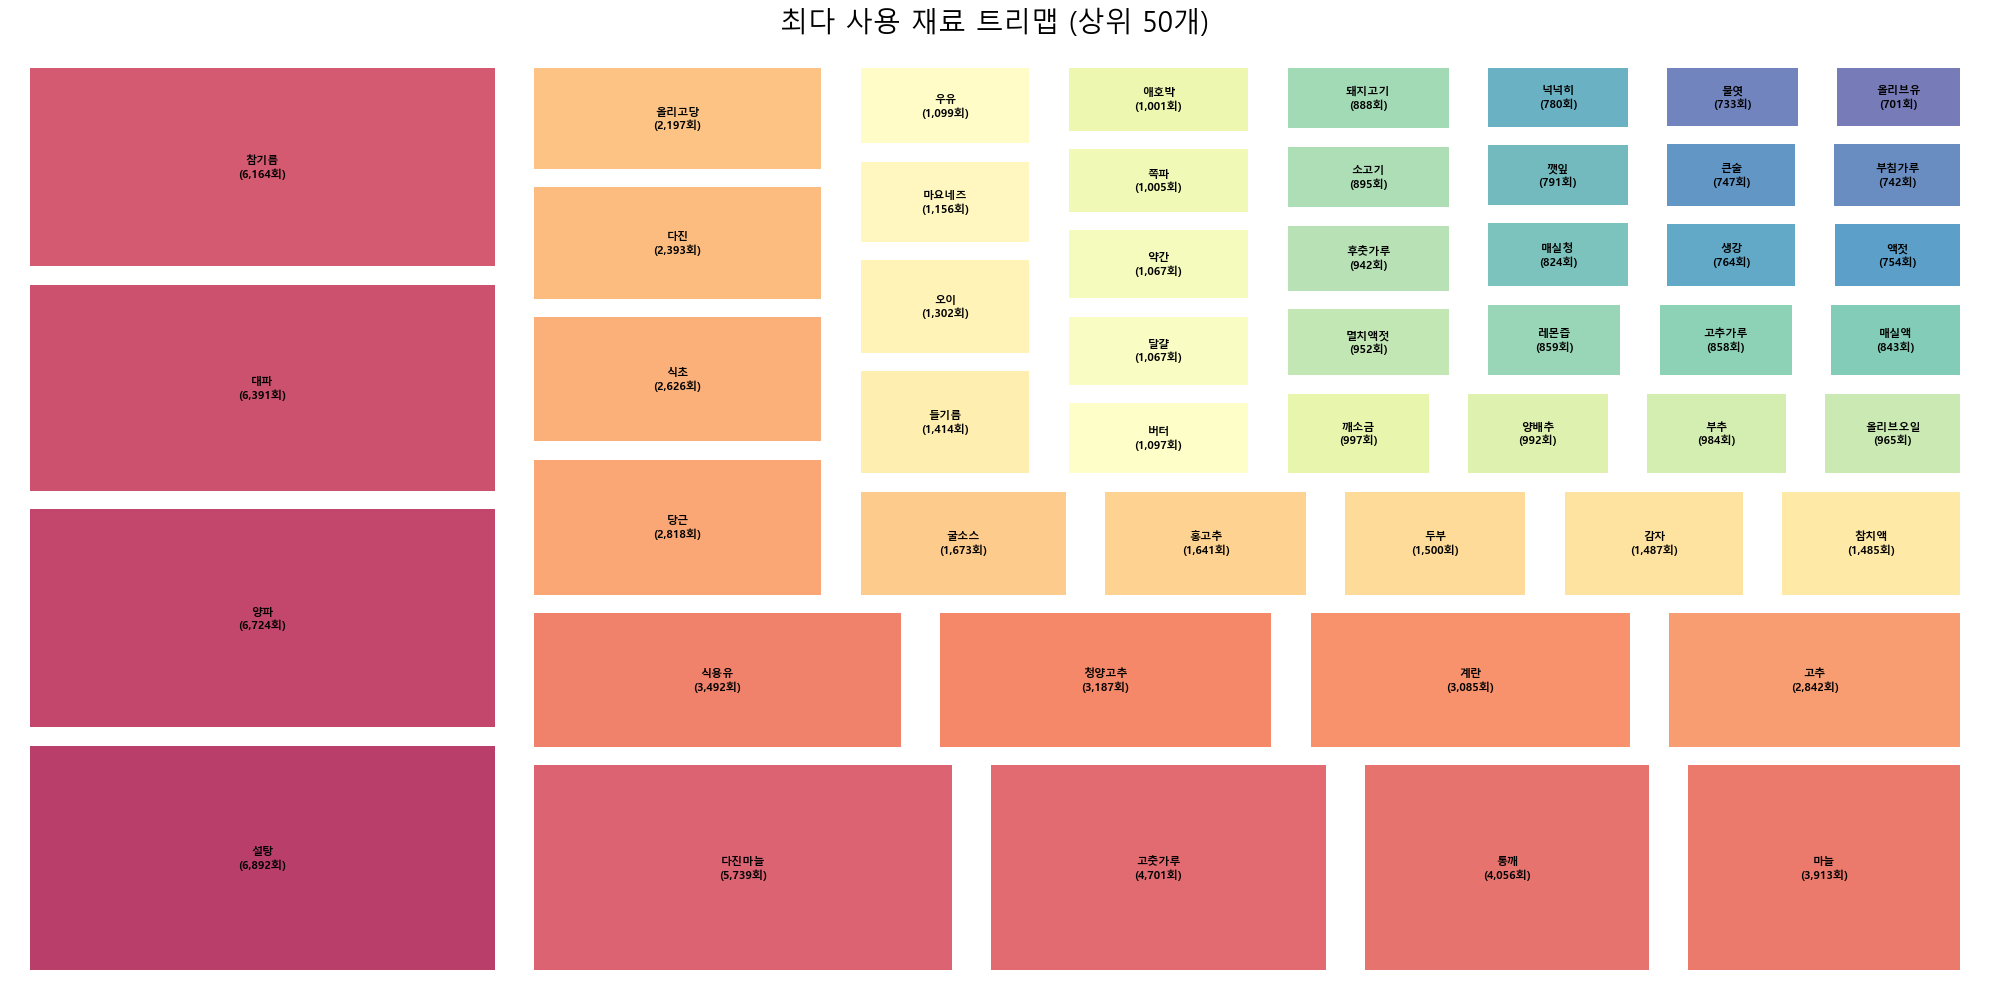

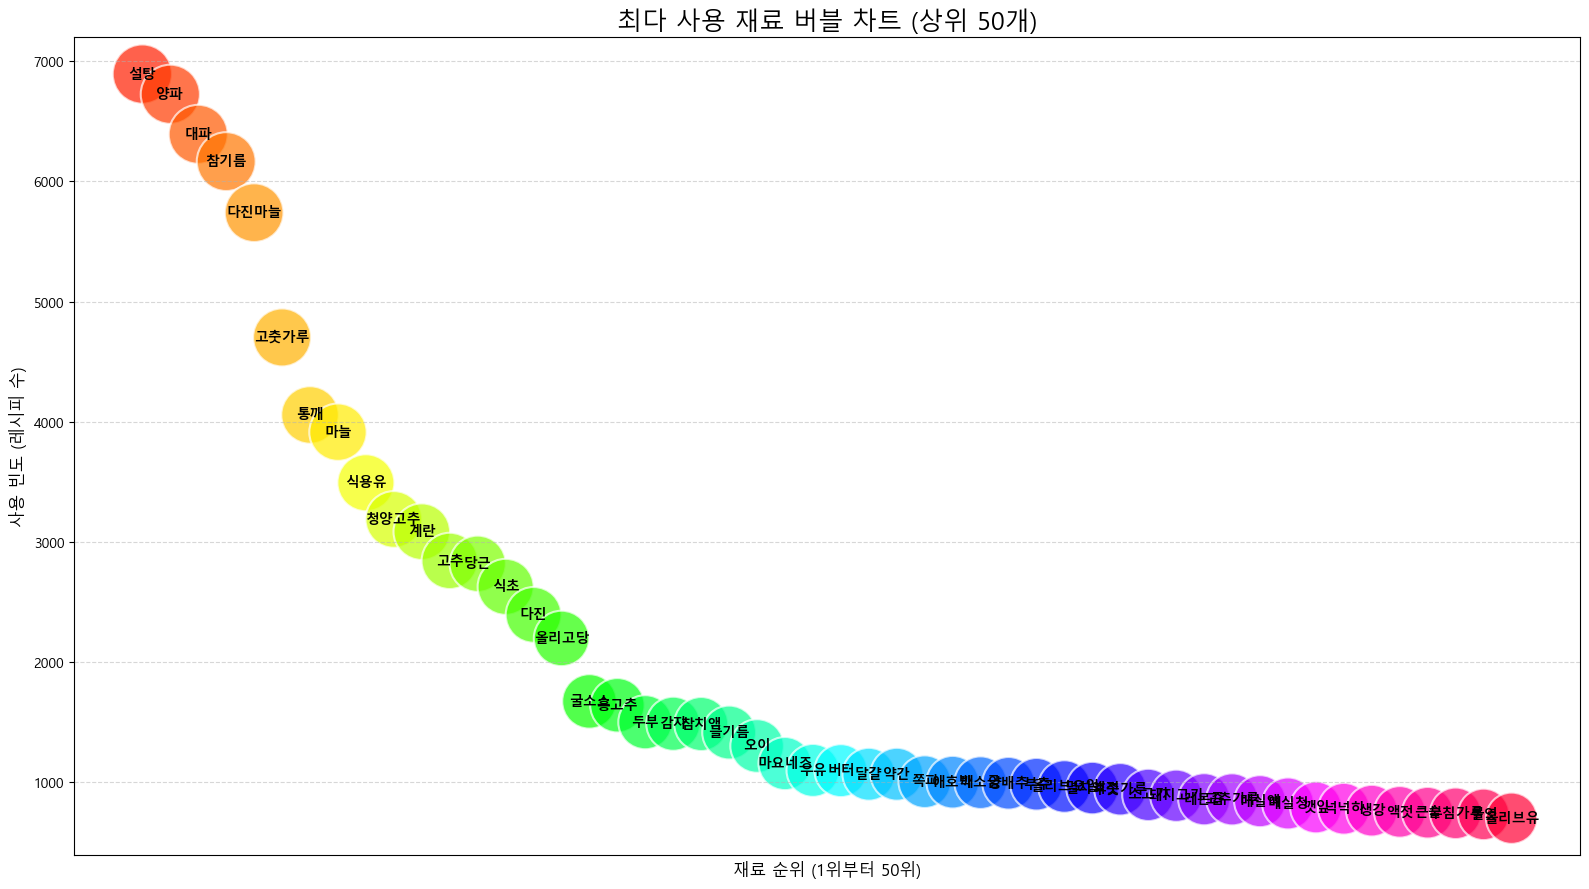

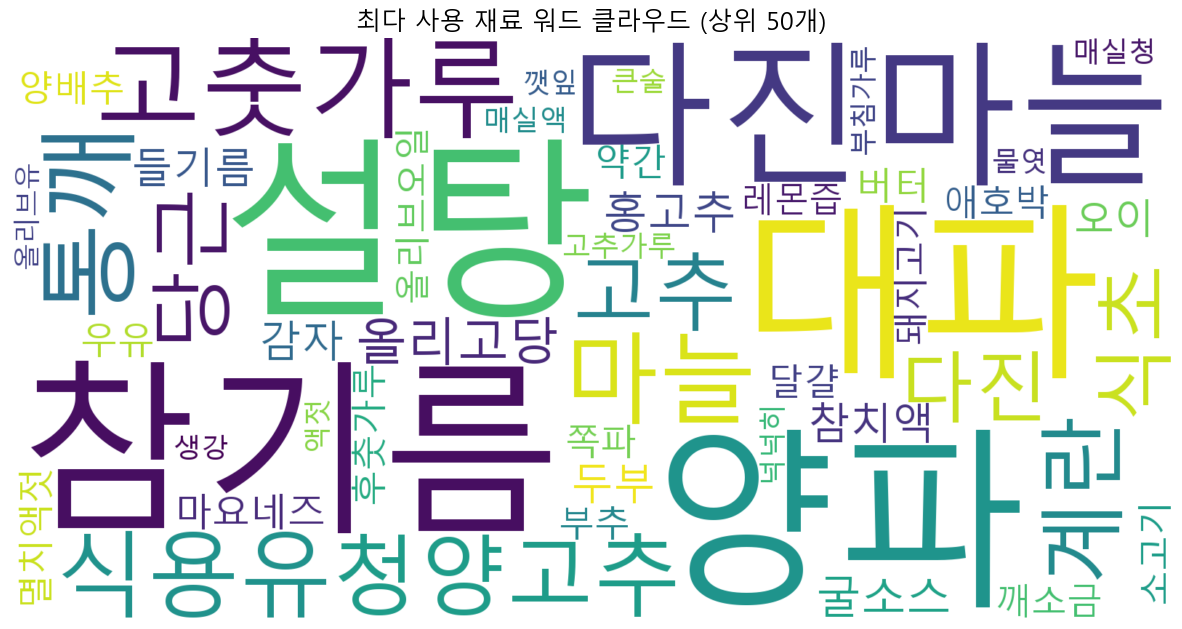

In [ ]:
## 트리맵 시각화 (Treemap)

sizes = top_materials.values
labels = [f'{name}\n({count:,}회)' for name, count in top_materials.items()]

plt.figure(figsize=(20, 10))

squarify.plot(
    sizes=sizes,
    label=labels,
    color=sns.color_palette('Spectral', len(top_materials)),
    alpha=0.8,
    pad=True,
    text_kwargs={'fontsize': 8, 'color': 'black', 'fontweight': 'bold'}
)

plt.title(f'최다 사용 재료 트리맵 (상위 {top_n}개)', fontsize=20, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()



## 버블 차트 시각화 (Bubble Chart)

counts = top_materials.values
sizes = (np.log1p(counts) * 200) + 50 

plt.figure(figsize=(16, 9))
colors = sns.color_palette('hsv', len(top_materials))

plt.scatter(
    x=range(len(top_materials)), 
    y=counts,                    
    s=sizes,                     
    c=colors,                    
    alpha=0.7,
    edgecolors='w',
    linewidth=1.5
)

for i in range(len(top_materials)):
    txt = top_materials.index[i]
    plt.annotate(
        txt, 
        (i, counts[i]), 
        ha='center', va='center', fontsize=10, 
        fontweight='bold', color='black'
    )

plt.title(f'최다 사용 재료 버블 차트 (상위 {top_n}개)', fontsize=18)
plt.xlabel('재료 순위 (1위부터 50위)', fontsize=12)
plt.ylabel('사용 빈도 (레시피 수)', fontsize=12)
plt.xticks([]) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



## 워드 클라우드 시각화 (Word Cloud)

wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', 
    background_color='white',
    width=1600,
    height=800,
    max_words=top_n, 
    prefer_horizontal=0.9
)

wordcloud.generate_from_frequencies(top_materials.to_dict())

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'최다 사용 재료 워드 클라우드 (상위 {top_n}개)', fontsize=18)
plt.axis('off') 
plt.show()

In [ ]:
#ipywidgets.HTML 충돌 방지를 위해 WidgetHTML로 리네임
from ipywidgets import VBox, HBox, widgets, Output, Layout, Button, HTML as WidgetHTML 
from IPython.display import display, HTML, clear_output
import pandas as pd
import re

# ----------------------------------------------------------------------
# --- UI 위젯 옵션 설정 ---

# 요리 상황 옵션 설정: float/NaN 값 방지 로직 포함
unique_sta_values = df['CKG_STA_ACTO_NM'].unique()
ckg_sta_list = [str(x) for x in unique_sta_values if pd.notna(x) and str(x) != 'nan']
ckg_sta_options = ['선택 안함'] + sorted(list(set(ckg_sta_list)))

# 요리 종류 옵션 설정: float/NaN 값 방지 로직 포함
unique_knd_values = df['CKG_KND_ACTO_NM'].unique()
ckg_knd_list = [str(x) for x in unique_knd_values if pd.notna(x) and str(x) != 'nan']
ckg_knd_options = ['선택 안함'] + sorted(list(set(ckg_knd_list)))

# --- UI 위젯 정의 ---
material_input = widgets.Text(
    value='',
    placeholder='예: 양파, 당근, 계란 (쉼표로 구분)',
    description='필수 재료:',
    style={'description_width': 'initial', 'font_size': '16px'},
    # 너비 유지 (65%)
    layout=widgets.Layout(width='65%')
)

ckg_sta_select = widgets.Dropdown(
    options=ckg_sta_options,
    value='선택 안함',
    description='요리 상황:',
    style={'description_width': 'initial', 'font_size': '14px'},
    layout=widgets.Layout(width='30%')
)

ckg_knd_select = widgets.Dropdown(
    options=ckg_knd_options,
    value='선택 안함',
    description='요리 종류:',
    style={'description_width': 'initial', 'font_size': '14px'},
    layout=widgets.Layout(width='30%')
)

search_button = widgets.Button(
    description='✨ 레시피 찾아보기 ✨',
    button_style='info',
    tooltip='입력한 재료와 조건으로 레시피를 검색합니다.',
   
    layout=widgets.Layout(width='25%', height='45px', font_weight='bold') 
)

output_area = widgets.Output()

# ---  검색 로직 함수  ---
def search_recipes(materials_str, ckg_sta, ckg_knd):
    input_materials = [m.strip().replace(' ', '') for m in re.split(r'[,| ]', materials_str) if m.strip()]
    
    if not input_materials:
        with output_area:
            output_area.clear_output()
            display(HTML("<h4 style='color: #e74c3c;'>⚠️ 재료를 입력해 주세요!</h4>"))
        return

    filtered_df = df.copy()
    if ckg_sta != '선택 안함':
        filtered_df = filtered_df[filtered_df['CKG_STA_ACTO_NM'] == ckg_sta]
    if ckg_knd != '선택 안함':
        filtered_df = filtered_df[filtered_df['CKG_KND_ACTO_NM'] == ckg_knd]
        
    if filtered_df.empty:
        with output_area:
            output_area.clear_output()
            display(HTML(f"<h4 style='color: #e74c3c;'>😭 선택한 조건에 맞는 레시피가 없습니다.</h4>"))
        return

    def get_matches_and_count(recipe_materials_str):
        if pd.isna(recipe_materials_str) or not recipe_materials_str:
            return 0, []
        
        recipe_materials_list = recipe_materials_str.replace('', ' ').split('|')
        match_count = 0
        matched_materials = []
        
        for input_mat in input_materials:
            if any(input_mat in mat.replace(' ', '') for mat in recipe_materials_list):
                match_count += 1
                matched_materials.append(input_mat)
                
        return match_count, matched_materials

    match_results = filtered_df['CKG_MTRL_CN'].apply(lambda x: get_matches_and_count(x))
    filtered_df['Match_Count'] = match_results.apply(lambda x: x[0])
    filtered_df['Matched_Materials'] = match_results.apply(lambda x: x[1])

    top_recipes = filtered_df.sort_values(by=['Match_Count', 'INQ_CNT'], ascending=[False, False])
    top_recipes = top_recipes[top_recipes['Match_Count'] > 0]
    final_results = top_recipes[['CKG_NM', 'CKG_TIME_NM', 'Match_Count', 'RCP_SNO', 'Matched_Materials']].head(7)
    
    with output_area:
        output_area.clear_output()
        if final_results.empty:
            display(HTML(f"<h4 style='color: #e74c3c;'>입력한 재료를 포함하는 레시피를 찾지 못했습니다.</h4>"))
            return

        result_title = f"""
        <h3 style='color: #2c3e50; border-bottom: 2px solid #3498db; padding-bottom: 5px; margin-top: 20px;'>
            ✅ 추천 레시피 ({len(final_results)}개)
        </h3>
        <p style='font-size: 14px; color: #7f8c8d;'>
            입력 재료: <b>{', '.join(input_materials)}</b>
        </p>
        """
        display(HTML(result_title))

        html_table = f"""
        <style>
            .recipe-table {{ width: 100%; border-collapse: collapse; box-shadow: 0 4px 8px rgba(0,0,0,0.1); border-radius: 8px; overflow: hidden; }}
            .recipe-table th, .recipe-table td {{ border: 1px solid #ecf0f1; padding: 12px; text-align: left; }}
            .recipe-table thead tr {{ background-color: #3498db; color: white; }}
            .recipe-link {{ color: #2980b9; text-decoration: none; font-weight: bold; }}
            .match-count {{ color: #27ae60; font-weight: bold; text-align: center; }}
        </style>
        <table class='recipe-table'>
            <thead>
                <tr>
                    <th style='width: 35%;'>레시피 제목 (클릭)</th>
                    <th style='width: 15%; text-align: center;'>소요 시간</th>
                    <th style='width: 15%; text-align: center;'>재료 일치 수</th>
                    <th style='width: 35%;'>일치된 재료</th>
                </tr>
            </thead>
            <tbody>
        """
        for index, row in final_results.iterrows():
            recipe_link = f"<a href='https://www.10000recipe.com/recipe/{row['RCP_SNO']}' target='_blank' class='recipe-link'>{row['CKG_NM']}</a>"
            matched_materials_str = ', '.join(row['Matched_Materials'])
            
            html_table += f"""
            <tr>
                <td>{recipe_link}</td>
                <td style='text-align: center;'>{row['CKG_TIME_NM']}</td>
                <td class='match-count'>{row['Match_Count']}개</td>
                <td>{matched_materials_str}</td>
            </tr>
            """
        html_table += "</tbody></table>"
        display(HTML(html_table))


# --- 이벤트 연결 ---
def on_button_click(b):
    search_recipes(material_input.value, ckg_sta_select.value, ckg_knd_select.value)

search_button.on_click(on_button_click)


# --- 메인 레시피 검색 UI 레이아웃 구성 (main_ui) ---
input_and_button = HBox([
    material_input,
    search_button
], layout=widgets.Layout(align_items='flex-end', width='100%', justify_content='space-between'))

condition_section = HBox([
    ckg_sta_select, 
    widgets.Label(value="", layout=widgets.Layout(width='5%')),
    ckg_knd_select
], layout=widgets.Layout(justify_content='center', width='100%'))

main_ui_elements = [
    WidgetHTML("<h2>🍳 레시피 추천 시스템</h2><p>✨ **가지고 계신 재료**를 입력하고, 요리 조건(선택 사항)을 선택하여 레시피를 추천받으세요!</p>"),
    input_and_button,
    condition_section,
    WidgetHTML("<hr style='border: 1px solid #bdc3c7;'>"),
    output_area
]

main_ui = VBox(main_ui_elements, layout=widgets.Layout(padding='20px', border='1px solid #ecf0f1', border_radius='10px', background='white'))
# ----------------------------------------------------------------------


# --- 스플래시 화면 및 최종 출력 (UI 렌더링) ---
splash_html = """
<style>
    @keyframes fadeIn {
        from { opacity: 0; transform: translateY(30px); }
        to { opacity: 1; transform: translateY(0); }
    }
    .splash-container {
        text-align: center; 
        padding: 80px 40px; 
        background: linear-gradient(135deg, #f0f7ff 0%, #e0e6f0 100%); 
        border-radius: 25px; 
        box-shadow: 0 15px 30px rgba(44, 62, 80, 0.2); 
        width: 90%; 
        max-width: 650px; 
        margin: 80px auto; 
        border: 1px solid #dcdcdc;
    }
    .splash-title {
        font-size: 3.5em; 
        color: #e67e22;
        margin-bottom: 10px;
        text-shadow: 3px 3px 6px rgba(0, 0, 0, 0.15);
        font-weight: 800;
        animation: fadeIn 1s ease-out;
    }
    .splash-subtitle {
        font-size: 1.4em; 
        color: #34495e;
        margin-bottom: 50px;
        font-weight: 300;
        animation: fadeIn 1.5s ease-out;
    }
</style>
<div class="splash-container">
    <div class="splash-title">지운이의 레시피 추천!!!!!!!</div>
    <div class="splash-subtitle">🌟 나만의 맞춤 레시피를 지금 바로 찾아보세요! 👩‍🍳</div>
</div>
"""

# 출력을 관리할 메인 컨테이너
main_container = Output()

# WidgetHTML 사용
splash_widget = WidgetHTML(splash_html) 

# 시작 버튼
start_button = Button(
    description='시작하기',
    button_style='success',
    layout=Layout(width='200px', height='50px'),
    style={'button_color': '#2ecc71', 'font_weight': 'bold', 'font_size': '18px'}
)
main_container = Output()
# 버튼 클릭 이벤트 핸들러
def on_start_clicked(b):
    with main_container:
        clear_output(wait=True)
        display(main_ui) 

start_button.on_click(on_start_clicked)

# 초기 화면 구성 (스플래시 + 버튼)
initial_screen = VBox([
    splash_widget, 
    start_button
], layout=Layout(align_items='center'))

# 메인 컨테이너에 초기 화면 표시
with main_container:
    display(initial_screen)

# 최종 출력: 이 변수를 셀의 마지막 줄에 두어 UI를 화면에 렌더링

with main_container:
    clear_output(wait=True)
    display(initial_screen)

clear_output(wait=True)
display(main_container)

Output()